# Face Recognition
The goal is to train a train a one-shot learning model recognizing person.

We gonna use Triplet Network for face recognition.
The network will be trained on the LFW dataset.

In [2]:
import tensorflow as tf
import time
import cv2
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
import os
import yaml

# Check if the GPU is available
print(tf.config.list_physical_devices('GPU'))

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

config = yaml.safe_load(open("config.yaml"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Triplet Model

In [8]:
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(ResNetBlock, self).__init__()
        self.embedding_dim = embedding_dim
        self.resnet = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(config["img_size"], config["img_size"], 3)
        )

        percentage_frozen_resnet = 0.85
        nb_layers = len(self.resnet.layers)
        for layer in self.resnet.layers[:int(percentage_frozen_resnet * nb_layers)]:
            layer.trainable = False

        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(self.embedding_dim, activation=None)
        self.l2_normalization = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))

    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        x = tf.keras.applications.resnet.preprocess_input(x)
        x = self.resnet(x)
        x = self.global_average_pooling(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.l2_normalization(x)
        return x
    
    # Hack to show the summary of the layer
    def summary(self):
        x = tf.keras.Input(shape=(None, None, 3))
        tmp_model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return tmp_model.summary()
    
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(ConvBlock, self).__init__()
        self.embedding_dim = embedding_dim

        self.conv1 = tf.keras.layers.Conv2D(96, (11, 11), strides=(1, 1), padding='valid', input_shape=(128, 128, 3))
        self.local_response_normalization1 = tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, alpha=1e-4, beta=0.75, bias=1.0))
        self.max_pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))

        self.conv2 = tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same')
        self.local_response_normalization2 = tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, alpha=1e-4, beta=0.75, bias=1.0))
        self.max_pooling2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))
        self.dropout1 = tf.keras.layers.Dropout(0.3)

        self.conv3 = tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')
        self.max_pooling3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))
        self.dropout2 = tf.keras.layers.Dropout(0.3)

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(self.embedding_dim)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, config["img_size"], config["img_size"], 3])])
    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        x = tf.keras.applications.resnet.preprocess_input(x)

        x = self.conv1(x)
        x = self.local_response_normalization1(x)
        x = self.max_pooling1(x)

        x = self.conv2(x)
        x = self.local_response_normalization2(x)
        x = self.max_pooling2(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.max_pooling3(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout3(x)
        x = self.dense2(x)
        return x
    
    # Hack to show the summary of the layer
    def summary(self):
        x = tf.keras.Input(shape=(config["img_size"], config["img_size"], 3))
        tmp_model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return tmp_model.summary()

class DistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DistanceLayer, self).__init__(**kwargs)

    def call(self, anchor, positive, negative):
        positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return positive_distance, negative_distance
    
class TripletNetwork(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(TripletNetwork, self).__init__()
        self.embedding_dim = embedding_dim
        
        self.conv_block = ResNetBlock(embedding_dim)
        self.distance_layer = DistanceLayer()

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, config["img_size"], config["img_size"], 9])])
    def call(self, inputs):
        anchor, positive, negative = tf.split(inputs, num_or_size_splits=3, axis=3)

        anchor_embedding = self.conv_block(anchor)
        positive_embedding = self.conv_block(positive)
        negative_embedding = self.conv_block(negative)

        positive_distance, negative_distance = self.distance_layer(anchor_embedding, positive_embedding, negative_embedding)

        return tf.stack([positive_distance, negative_distance], axis=1)


In [9]:
class TripletLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0, **kwargs):
        super(TripletLoss, self).__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        positive_distance, negative_distance = tf.split(y_pred, num_or_size_splits=2, axis=1)
        loss = tf.maximum(0.0, positive_distance - negative_distance + self.margin)
        return tf.reduce_mean(loss)
    
class TripletAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="triplet_accuracy", **kwargs):
        super(TripletAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        positive_distance, negative_distance = tf.split(y_pred, num_or_size_splits=2, axis=1)
        correct = tf.cast(positive_distance < negative_distance, tf.float32)
        self.total.assign_add(tf.reduce_sum(correct))
        self.count.assign_add(tf.cast(tf.size(correct), tf.float32))

    def result(self):
        return self.total / self.count

    def reset_state(self):
        self.total.assign(0)
        self.count.assign(0)

In [10]:
# Create the model
model = TripletNetwork(embedding_dim=config["embedding_dim"])
triplet_loss = TripletLoss()
triplet_accuracy = TripletAccuracy()
model.compile(optimizer=tf.keras.optimizers.Adam(config["triplet_learning_rate"]),
              loss=triplet_loss, metrics=[triplet_accuracy])

In [11]:
# Here we say that the image can have any size (with 3 channels RGB)
inputs = tf.keras.Input(shape=(config["img_size"], config["img_size"], 3 * 3)) # 3 images

In [12]:
model(inputs)

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'triplet_network_1')>

In [13]:
# ConvBlock summary
#print(model.conv_block.summary())

In [14]:
# Model summary
print(model.summary())

Model: "triplet_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_block_1 (ResNetBloc  multiple                 23849984  
 k)                                                              
                                                                 
 distance_layer_1 (DistanceL  multiple                 0         
 ayer)                                                           
                                                                 
Total params: 23,849,984
Trainable params: 12,351,616
Non-trainable params: 11,498,368
_________________________________________________________________
None


# Dataset

#### Download dataset

In [15]:
import opendatasets as od

dataset = 'https://www.kaggle.com/datasets/stoicstatic/face-recognition-dataset/'
od.download(dataset)
extracted_faces_dataset_path = Path("face-recognition-dataset\Extracted Faces\Extracted Faces")
# the triplets.npy are from https://www.kaggle.com/code/stoicstatic/face-recognition-siamese-w-triplet-loss/input?select=triplets.npy
triplets = np.load('triplets.npy', allow_pickle=True)

Skipping, found downloaded files in ".\face-recognition-dataset" (use force=True to force download)


#### Split dataset

In [16]:
# Random shuffle triplets
np.random.shuffle(triplets)

percentage_train = config["data_split"]
x_train, x_val = triplets[:int(percentage_train * len(triplets))], triplets[int(percentage_train * len(triplets)):]

In [17]:
def get_extracted_face_path(data: np.ndarray) -> Path:
    result_path = extracted_faces_dataset_path
    return result_path / str(data[0]) / f"{data[1]}.jpg"

def read_image(path: Path) -> np.ndarray:
    image = cv2.imread(path.as_posix())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

#### Example of triplet

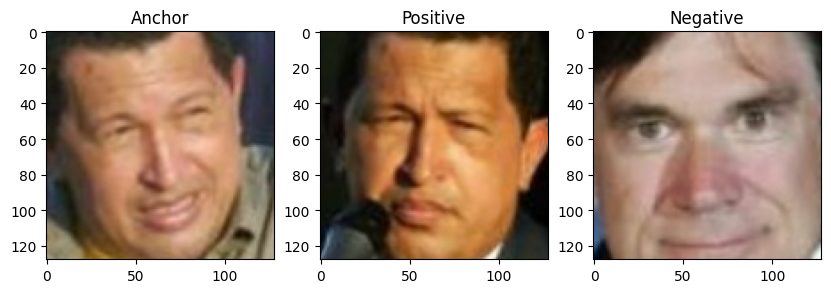

In [18]:
# Show an example of triplet
random_triplet = random.choice(x_train)
anchor = read_image(get_extracted_face_path(random_triplet[0]))
positive = read_image(get_extracted_face_path(random_triplet[1]))
negative = read_image(get_extracted_face_path(random_triplet[2]))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(anchor)
ax[0].set_title('Anchor')
ax[1].imshow(positive)
ax[1].set_title('Positive')
ax[2].imshow(negative)
ax[2].set_title('Negative')
plt.show()

#### Create tf.Dataset

In [19]:
# Create tf.Dataset that changes every epoch
def create_dataset(X, batch_size):
    while True:
        np.random.shuffle(X)
        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size]
            a = np.array([read_image(get_extracted_face_path(data[0])) for data in x_batch])
            p = np.array([read_image(get_extracted_face_path(data[1])) for data in x_batch])
            n = np.array([read_image(get_extracted_face_path(data[2])) for data in x_batch])
            
            # result = (B, H, W, 3 * 3)
            result = np.concatenate([a, p, n], axis=-1)
            yield result, np.zeros((len(x_batch), 1)) # Fake labels

# Create the dataset
triplet_train_dataset = tf.data.Dataset.from_generator(lambda: create_dataset(x_train, config["triplet_batch_size"]), output_types=(tf.float32, tf.float32), output_shapes=((None, config["img_size"], config["img_size"], 3 * 3), (None, 1)))
triplet_val_dataset = tf.data.Dataset.from_generator(lambda: create_dataset(x_val, config["triplet_batch_size"]), output_types=(tf.float32, tf.float32), output_shapes=((None, config["img_size"], config["img_size"], 3 * 3), (None, 1)))

triplet_train_dataset = triplet_train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
triplet_val_dataset = triplet_val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Train

In [20]:
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path: Path):
        super(SaveModelCallback).__init__()
        self.save_path = save_path
        os.makedirs(self.save_path, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        loss = logs['loss']
        accuracy = logs['triplet_accuracy']
        saved_weights_path = self.save_path / f"weights_epoch_{epoch}_loss_{loss:.2f}_accuracy_{accuracy:.2f}.h5"
        self.model.save_weights(saved_weights_path.as_posix())

In [21]:
start = time.time()
steps_per_epoch = len(x_train) // config["triplet_batch_size"]
validation_steps = len(x_val) // config["triplet_batch_size"]
hist = model.fit(triplet_train_dataset,
                 batch_size=config["triplet_batch_size"],
                 epochs=config["triplet_epochs"],
                 verbose=1,
                 steps_per_epoch=steps_per_epoch,
                 validation_data=triplet_val_dataset,
                 validation_steps=validation_steps,
                 callbacks=[SaveModelCallback(Path("results/triplet_weights/"))]
            )
end = time.time()

print("Training time: ", end - start)

Epoch 1/10


99/99 [==============================] - 24s 161ms/step - loss: 0.3623 - triplet_accuracy: 0.8813 - val_loss: 0.1888 - val_triplet_accuracy: 0.9500
Epoch 2/10
99/99 [==============================] - 15s 152ms/step - loss: 0.1250 - triplet_accuracy: 0.9760 - val_loss: 0.1563 - val_triplet_accuracy: 0.9719
Epoch 3/10
99/99 [==============================] - 15s 151ms/step - loss: 0.0513 - triplet_accuracy: 0.9952 - val_loss: 0.1260 - val_triplet_accuracy: 0.9719
Epoch 4/10
99/99 [==============================] - 15s 152ms/step - loss: 0.0234 - triplet_accuracy: 0.9995 - val_loss: 0.1275 - val_triplet_accuracy: 0.9656
Epoch 5/10
99/99 [==============================] - 15s 151ms/step - loss: 0.0142 - triplet_accuracy: 1.0000 - val_loss: 0.1251 - val_triplet_accuracy: 0.9719
Epoch 6/10
99/99 [==============================] - 15s 152ms/step - loss: 0.0093 - triplet_accuracy: 1.0000 - val_loss: 0.1004 - val_triplet_accuracy: 0.9750
Epoch 7/10
99/99 [==============================] - 15s 1

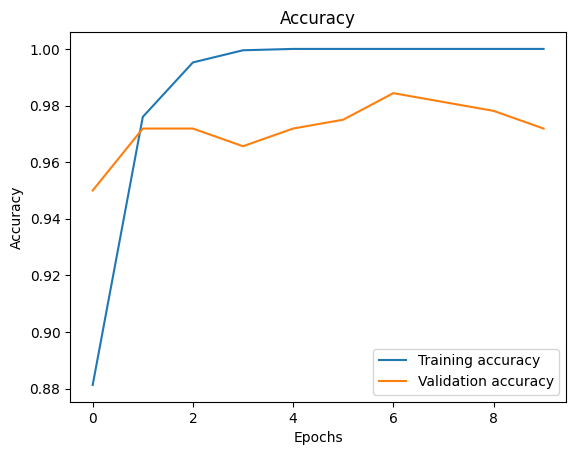

In [22]:
def plot_loss(hist, filename="loss"):
    plt.clf()
    plt.plot(hist.history["loss"], label="Training loss")
    plt.plot(hist.history["val_loss"], label="Validation loss")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(f"results/{filename}.png")

def plot_accuracy(hist, accuracy_key, filename="accuracy"):
    plt.clf()
    plt.plot(hist.history[accuracy_key], label="Training accuracy")
    plt.plot(hist.history[f"val_{accuracy_key}"], label="Validation accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig(f"results/{filename}.png")

plot_loss(hist, filename="triplet_loss")
plot_accuracy(hist, accuracy_key="triplet_accuracy", filename="triplet_accuracy")

In [23]:
from sklearn.manifold import TSNE

cnn = model.conv_block

new_triplet_val_dataset = triplet_val_dataset.map(lambda x, y: (tf.split(x, num_or_size_splits=3, axis=3), y)) # (3, Batch, H, W, 3)
# For each anchor, positive, negative
# predict the embedding
anchor_embeddings = None
positive_embeddings = None
negative_embeddings = None
for idx in range(new_triplet_val_dataset.take(1).as_numpy_iterator().next()[0].shape[0]):
    batch_image = new_triplet_val_dataset.take(1).as_numpy_iterator().next()[0][idx]
    if idx == 0:
        anchor_embeddings = cnn(batch_image)
    elif idx == 1:
        positive_embeddings = cnn(batch_image)
    else:
        negative_embeddings = cnn(batch_image)

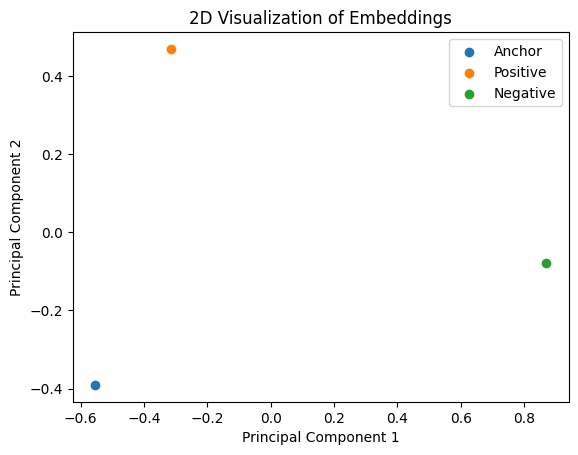

In [24]:
from sklearn.decomposition import PCA

one_sample_anchor_embedding = anchor_embeddings[1]
one_sample_positive_embedding = positive_embeddings[1]
one_sample_negative_embedding = negative_embeddings[1]
embeddings_matrix = np.vstack([one_sample_anchor_embedding, one_sample_positive_embedding, one_sample_negative_embedding])

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

# Plot the embeddings in 2D
plt.scatter(reduced_embeddings[:1, 0], reduced_embeddings[:1, 1], label='Anchor')
plt.scatter(reduced_embeddings[1:2, 0], reduced_embeddings[1:2, 1], label='Positive')
plt.scatter(reduced_embeddings[2:, 0], reduced_embeddings[2:, 1], label='Negative')
plt.legend()
plt.title('2D Visualization of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Prediction Part

#### Model

In [25]:
class PredictionModel(tf.keras.Model):
    def __init__(self, triplet_loss_model: TripletNetwork):
        super(PredictionModel, self).__init__()
        self.conv_block = triplet_loss_model.conv_block
        self.sigmoid = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # inputs = (B, H, W, 3 * 2)
        a, b = tf.split(inputs, num_or_size_splits=2, axis=3)
        a_embedding = self.conv_block(a)
        b_embedding = self.conv_block(b)
        distance = tf.reduce_sum(tf.square(a_embedding - b_embedding), axis=-1)
        x = tf.expand_dims(distance, axis=-1)
        x = self.sigmoid(x)
        return x

In [26]:
# Create the model
prediction_model = PredictionModel(model)
prediction_accy = tf.keras.metrics.BinaryAccuracy()
prediction_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[prediction_accy])

#### New dataset

In [27]:
def create_duo_dataset(X, batch_size):
    while True:
        np.random.shuffle(X)
        for i in range(0, len(X), batch_size // 2):
            x_batch = X[i:i+batch_size]
            # Same person
            a = np.array([read_image(get_extracted_face_path(data[0])) for data in x_batch])
            b = np.array([read_image(get_extracted_face_path(data[1])) for data in x_batch])
            
            # Different person
            c = np.array([read_image(get_extracted_face_path(data[0])) for data in x_batch])
            d = np.array([read_image(get_extracted_face_path(data[2])) for data in x_batch])

            result1 = np.concatenate([a, b], axis=-1)
            result2 = np.concatenate([c, d], axis=-1)
            # result = (B, H, W, 3 * 2)
            result = np.concatenate([result1, result2], axis=0)
            y_true = np.concatenate([np.ones(len(x_batch)), np.zeros(len(x_batch))])
            yield result, y_true

# Create the dataset
duo_triplet_train_dataset = tf.data.Dataset.from_generator(lambda: create_duo_dataset(x_train, config["prediction_batch_size"]), output_types=(tf.float32, tf.float32), output_shapes=((None, config["img_size"], config["img_size"], 3 * 2), (None)))
duo_val_dataset = tf.data.Dataset.from_generator(lambda: create_duo_dataset(x_val, config["prediction_batch_size"]), output_types=(tf.float32, tf.float32), output_shapes=((None, config["img_size"], config["img_size"], 3 * 2), (None)))

#### Train

In [28]:
start = time.time()
steps_per_epoch = len(x_train) // config["prediction_batch_size"]
validation_steps = len(x_val) // config["prediction_batch_size"]
prediction_hist = prediction_model.fit(
                            duo_triplet_train_dataset,
                            batch_size=config["prediction_batch_size"],
                            epochs=config["prediction_epochs"],
                            verbose=1,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=duo_val_dataset,
                            validation_steps=validation_steps
                        )
end = time.time()

print("Training time: ", end - start)

Epoch 1/20


99/99 [==============================] - 34s 299ms/step - loss: 0.5568 - binary_accuracy: 0.5958 - val_loss: 0.5920 - val_binary_accuracy: 0.6766
Epoch 2/20
99/99 [==============================] - 29s 293ms/step - loss: 0.4968 - binary_accuracy: 0.7946 - val_loss: 0.5062 - val_binary_accuracy: 0.8359
Epoch 3/20
99/99 [==============================] - 28s 287ms/step - loss: 0.4439 - binary_accuracy: 0.8696 - val_loss: 0.4644 - val_binary_accuracy: 0.8844
Epoch 4/20
99/99 [==============================] - 28s 282ms/step - loss: 0.4196 - binary_accuracy: 0.8914 - val_loss: 0.4209 - val_binary_accuracy: 0.8813
Epoch 5/20
99/99 [==============================] - 28s 280ms/step - loss: 0.3707 - binary_accuracy: 0.9223 - val_loss: 0.3755 - val_binary_accuracy: 0.8984
Epoch 6/20
99/99 [==============================] - 28s 283ms/step - loss: 0.3578 - binary_accuracy: 0.9266 - val_loss: 0.3785 - val_binary_accuracy: 0.8922
Epoch 7/20
99/99 [==============================] - 28s 279ms/step - 

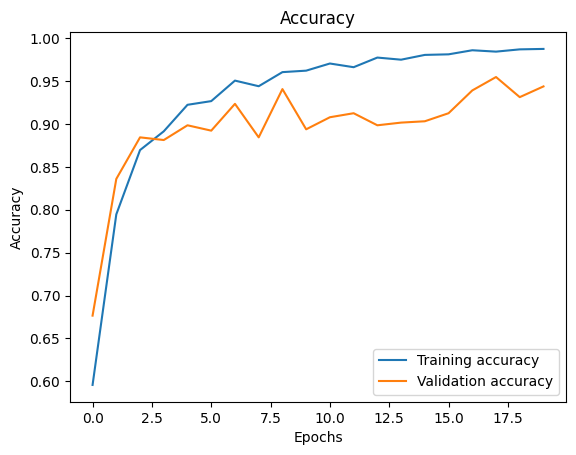

In [29]:
plot_loss(prediction_hist, filename="prediction_loss")
plot_accuracy(prediction_hist, accuracy_key="binary_accuracy", filename="prediction_accuracy")

In [30]:
prediction_model.save('results/prediction_model')

INFO:tensorflow:Assets written to: results/prediction_model\assets


INFO:tensorflow:Assets written to: results/prediction_model\assets


# TEST

In [6]:
prediction_model = tf.keras.models.load_model('results_v2/prediction_model')

#### Debug

In [11]:
def read_image(path: Path) -> np.ndarray:
    image = cv2.imread(path.as_posix())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_images(img1_path, img2_path):
    img1 = read_image(img1_path)
    img2 = read_image(img2_path)
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img1)
    ax[0].set_title('Image 1')
    ax[1].imshow(img2)
    ax[1].set_title('Image 2')
    plt.show()

def show_faces(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img1)
    ax[0].set_title('Image 1')
    ax[1].imshow(img2)
    ax[1].set_title('Image 2')
    plt.show()

#### Test in PROD

In [12]:
import face_recognition

def get_cropped_face_from_image_path(image_path: Path) -> np.ndarray:
    image = cv2.imread(image_path.as_posix())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) == 0:
        return None
    top, right, bottom, left = face_locations[0]

    # magin = 3% resolution of the image
    margin = int(0.03 * image.shape[0])
    top = max(0, top - margin)
    left = max(0, left - margin)
    bottom = min(image.shape[0], bottom + margin)
    right = min(image.shape[1], right + margin)

    return image[top:bottom, left:right]

In [13]:
def predict_image(model, img1, img2):
    images = np.concatenate([img1, img2], axis=-1)
    images = tf.cast(images, tf.float32)
    res = model.predict(np.array([images]))
    confidence = res[0][0]
    if confidence > 0.5:
        print("Same person ! Confidence: ", confidence)
    else:
        print("Different person ! Confidence: ", confidence)

def pad_and_resize_image(image: np.ndarray, target_size=(128, 128)) -> np.ndarray:
    h, w, _ = image.shape
    if h > w:
        new_h = target_size[0]
        new_w = int(w * new_h / h)
    else:
        new_w = target_size[1]
        new_h = int(h * new_w / w)
    image = cv2.resize(image, (new_w, new_h))
    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image

def is_it_the_same_person(model, img1_path, img2_path):
    show_images(img1_path, img2_path)
    img1 = get_cropped_face_from_image_path(img1_path)
    img2 = get_cropped_face_from_image_path(img2_path)
    if img1 is None:
        print(f"No face detected in {img1_path}")
        return
    if img2 is None:
        print(f"No face detected in {img2_path}")
        return
    show_faces(img1, img2)
    
    img1 = pad_and_resize_image(img1)
    img2 = pad_and_resize_image(img2)
    show_faces(img1, img2)

    predict_image(model, img1, img2)

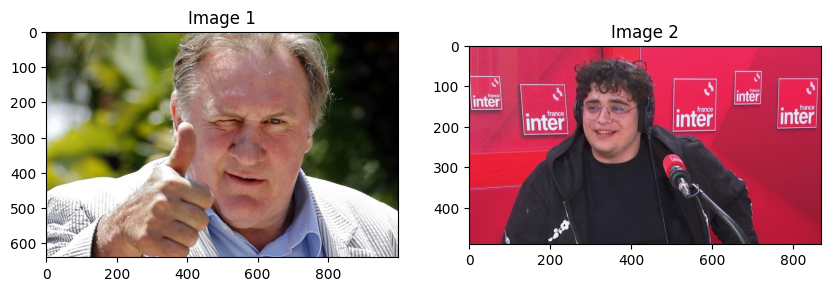

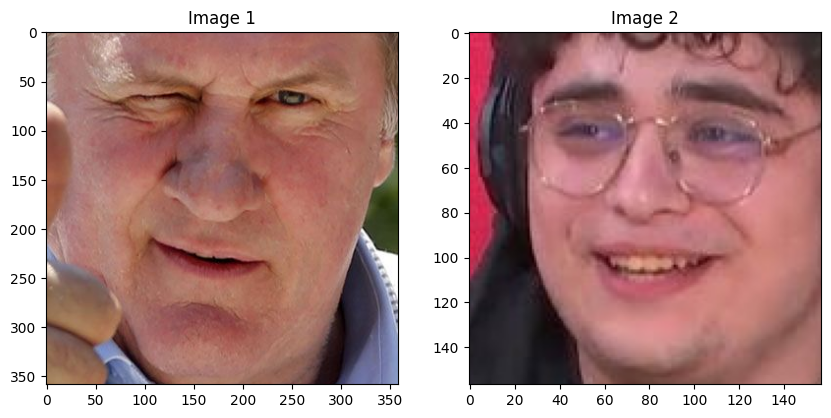

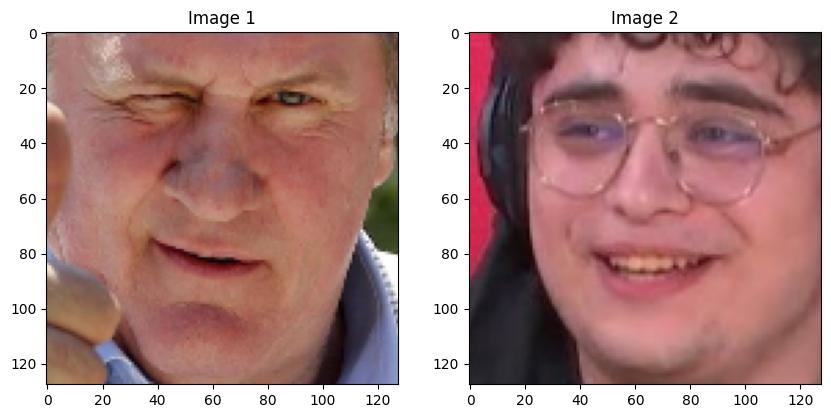

1/1 [==============================] - 0s 74ms/step
Different person ! Confidence:  0.02319834


In [75]:
fdp_path = Path("test/fdp.png")
chad1_path = Path("test/kameto1.jpg")
is_it_the_same_person(prediction_model, fdp_path, chad1_path)

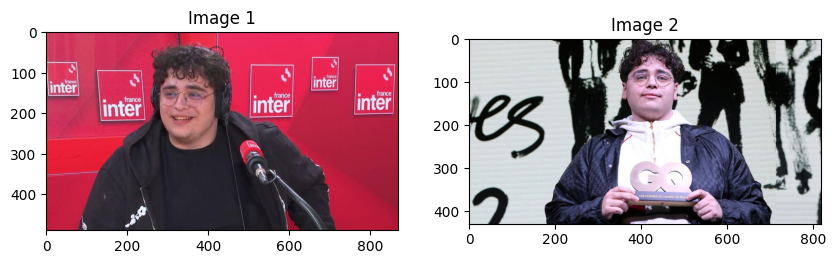

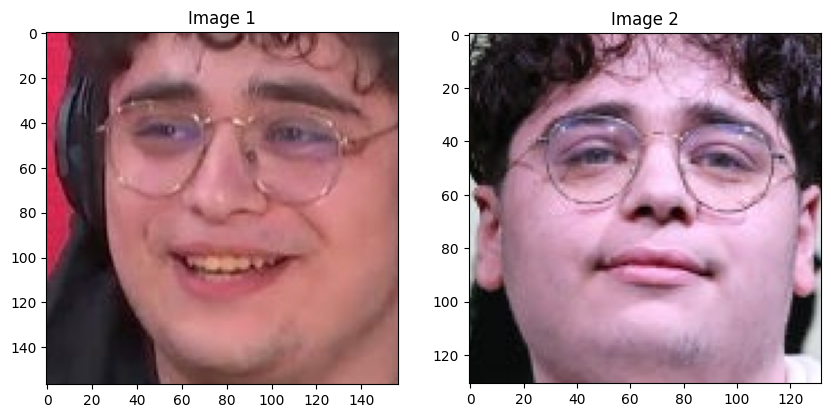

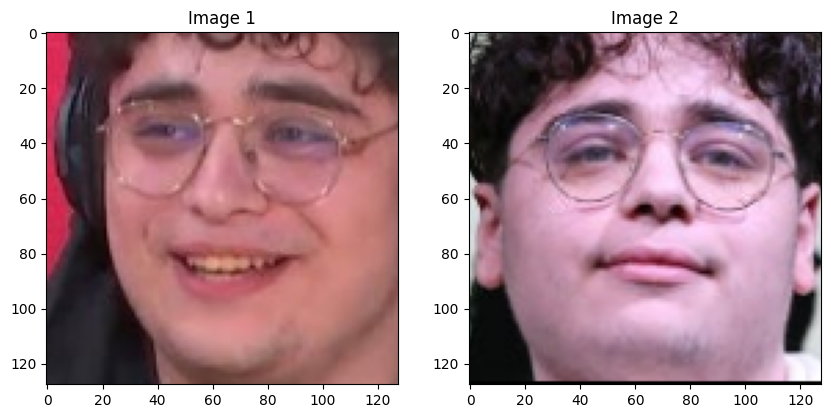

1/1 [==============================] - 0s 66ms/step
Same person ! Confidence:  0.8137141


In [77]:
kam1_path = Path("test/kameto1.jpg")
kam2_path = Path("test/kameto2.jpg")
is_it_the_same_person(prediction_model, kam1_path, kam2_path)

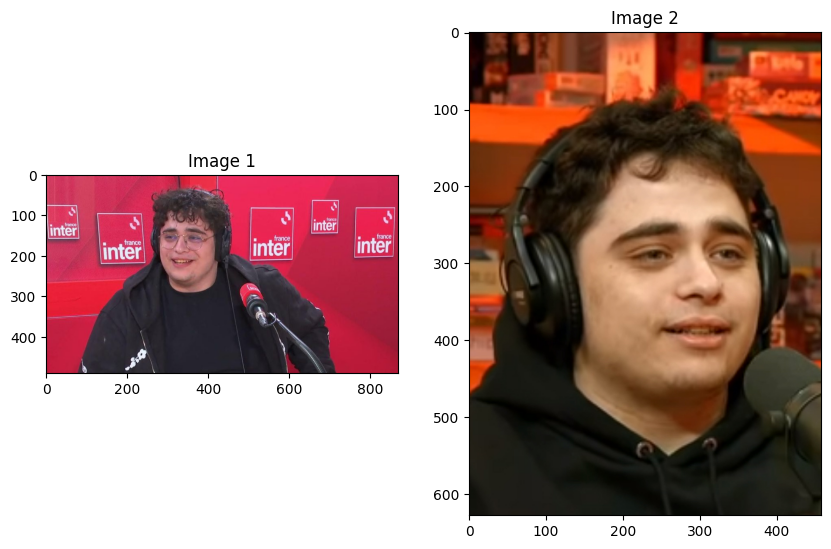

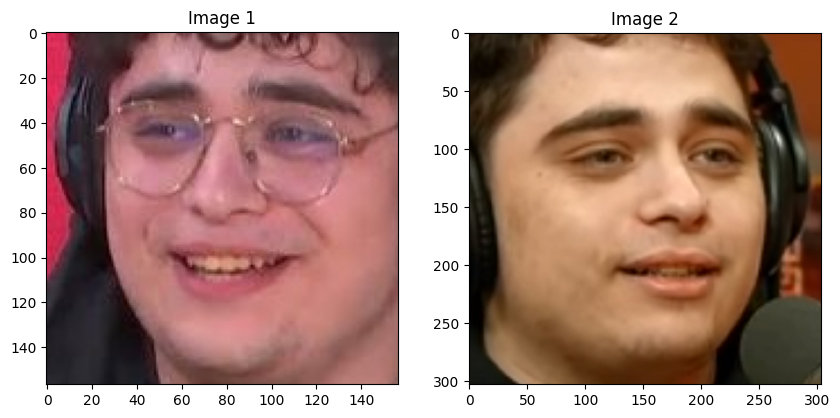

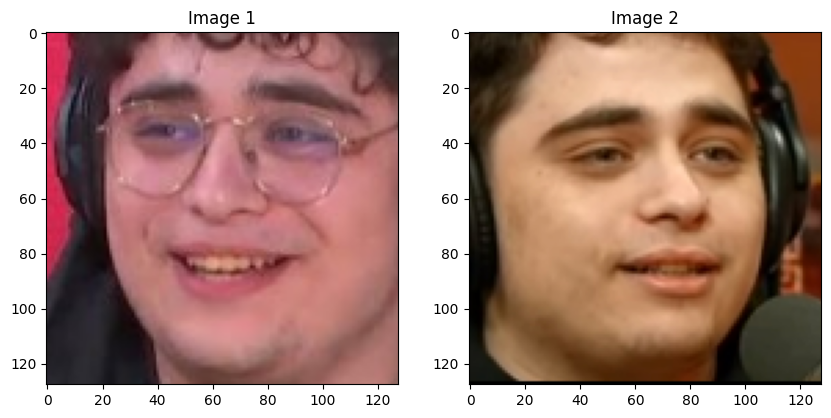

1/1 [==============================] - 0s 27ms/step
Same person ! Confidence:  0.7726768


In [78]:
kam1_path = Path("test/kameto1.jpg")
kam2_path = Path("test/kameto3.jpg")
is_it_the_same_person(prediction_model, kam1_path, kam2_path)

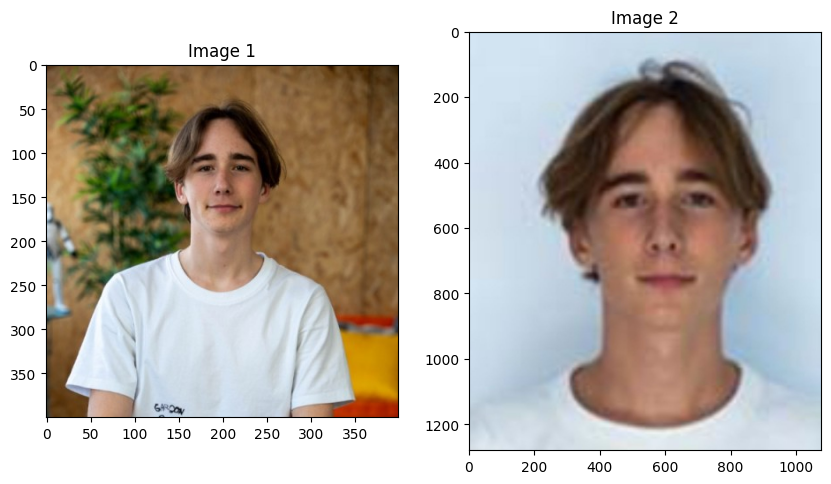

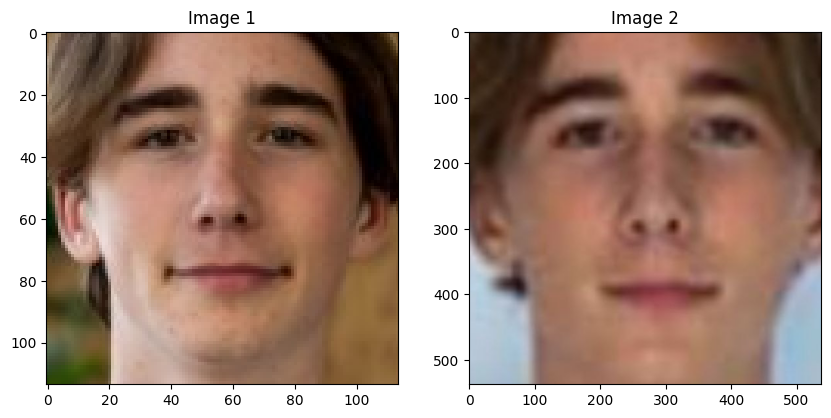

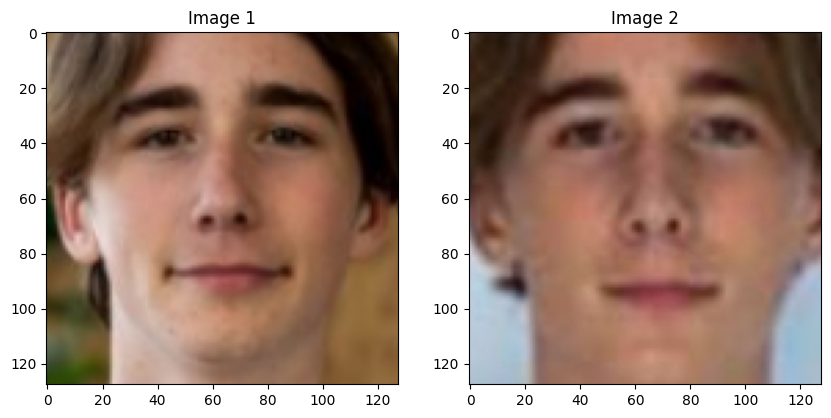

1/1 [==============================] - 3s 3s/step
Same person ! Confidence:  0.56583726


In [14]:
kam1_path = Path("test/allan.jpg")
kam2_path = Path("test/allan_2.jpg")
is_it_the_same_person(prediction_model, kam1_path, kam2_path)

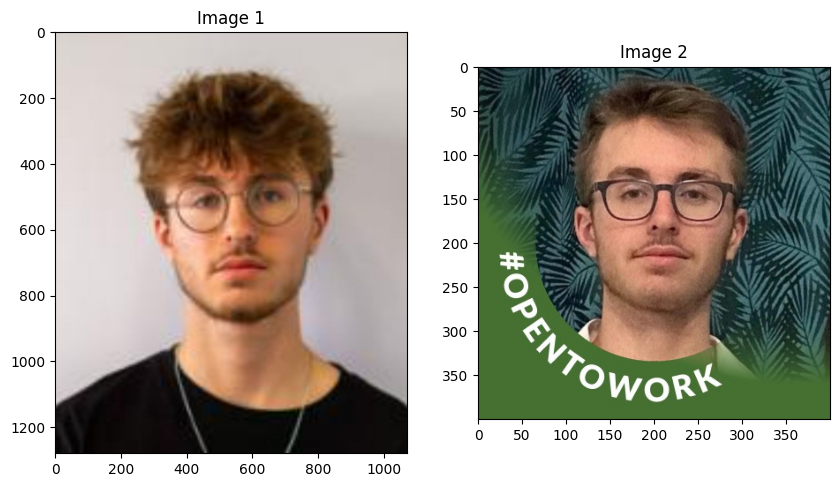

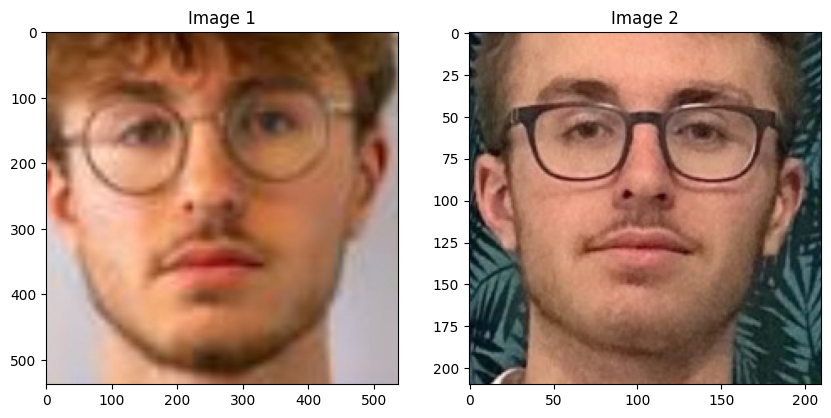

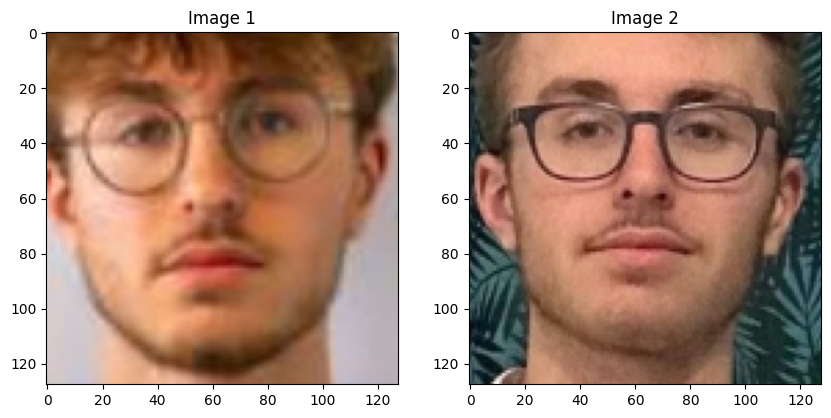

1/1 [==============================] - 0s 25ms/step
Different person ! Confidence:  0.39464644


In [15]:
kam1_path = Path("test/axel.jpg")
kam2_path = Path("test/axel_2.jpg")
is_it_the_same_person(prediction_model, kam1_path, kam2_path)